In [1]:
#from helper_functions import get_llm_response, print_llm_response, display_table
from IPython.display import Markdown, display, HTML
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# this notebook is simply to check if a student uses drugs based on whether their parents used or not

In [2]:
# account 
drug_use = pd.read_csv("drug_use.csv")

In [3]:
drug_use['student'].value_counts()

student
not     226
uses    219
Name: count, dtype: int64

In [4]:
# a function to perform eda on our dataset
def perform_eda(data, target_column=None, num_bins=20):
    """
    Performs exploratory data analysis (EDA) on a dataset.

    Args:
        data (pd.DataFrame): The dataset to analyze.
        target_column (str, optional): Name of the target column for analysis. Defaults to None.
        num_bins (int, optional): Number of bins for histograms. Defaults to 20.

    Returns:
        None: Displays EDA results including statistics, distributions, and visualizations.
    """
    print("===== EDA Summary =====\n")
    
    # 1. Basic Information
    print("1. Basic Information:")
    print(f"Shape of dataset: {data.shape}")
    print("\nData Types:\n", data.dtypes)
    print("\nSample Data:\n", data.head(), "\n")

    # 2. Check for Missing Values
    print("2. Missing Values:")
    missing_values = data.isnull().sum()
    if missing_values.any():
        print(missing_values[missing_values > 0], "\n")
    else:
        print("No missing values detected.\n")
    
    # 3. Summary Statistics
    print("3. Summary Statistics:")
    print(data.describe(include='all'), "\n")

    # 4. Target Column Analysis
    if target_column and target_column in data.columns:
        print(f"4. Target Column Analysis: {target_column}")
        if data[target_column].dtype == 'object':
            # If the target column is categorical
            print("\nValue Counts:\n", data[target_column].value_counts(), "\n")
            try:
                plt.figure(figsize=(8, 4))
                sns.countplot(y=target_column, data=data, order=data[target_column].value_counts().index)
                plt.title(f'Distribution of Target Column: {target_column}')
                plt.tight_layout()  # Adjust layout to prevent overlap
                plt.show()
            except Exception as e:
                print(f"Error plotting target column: {e}")
        elif data[target_column].dtype in ['int64', 'float64']:
            # If the target column is numeric (int64 or float64)
            try:
                sns.histplot(data[target_column], kde=True, bins=num_bins)
                plt.title(f'Distribution of Target Column: {target_column}')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error plotting target column: {e}")
    else:
        print("No target column specified or invalid target column.")

    # 5. Visualizations for Numeric Features
    print("5. Numeric Feature Distributions:")
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_columns) > 0:
        try:
            data[numeric_columns].hist(figsize=(12, 8), bins=num_bins)
            plt.suptitle("Numeric Feature Distributions", fontsize=16)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting numeric distributions: {e}")
    else:
        print("No numeric column found to plot")

    # 6. Correlation Heatmap
    print("6. Correlation Analysis:")
    if len(numeric_columns) > 0:
        try:
            correlation_matrix = data[numeric_columns].corr()
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title("Correlation Heatmap")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting heatmap: {e}")
    else:
        print("No numeric column found to perform correlation")

    # 7. Categorical Feature Analysis
    print("7. Categorical Features:")
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns
    if len(categorical_columns) > 0:
        for column in categorical_columns:
            try:
                print(f"\nValue Counts for {column}:\n", data[column].value_counts())
                plt.figure(figsize=(8, 4))
                sns.countplot(y=column, data=data, order=data[column].value_counts().index)
                plt.title(f"Distribution of {column}")
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error plotting {column}: {e}")
    else:
        print("No categorical features found.")

    print("\n===== EDA Complete =====")


===== EDA Summary =====

1. Basic Information:
Shape of dataset: (445, 2)

Data Types:
 student    object
parents    object
dtype: object

Sample Data:
   student parents
0    uses    used
1    uses    used
2    uses    used
3    uses    used
4    uses    used 

2. Missing Values:
No missing values detected.

3. Summary Statistics:
       student parents
count      445     445
unique       2       2
top        not     not
freq       226     235 

No target column specified or invalid target column.
5. Numeric Feature Distributions:
No numeric column found to plot
6. Correlation Analysis:
No numeric column found to perform correlation
7. Categorical Features:

Value Counts for student:
 student
not     226
uses    219
Name: count, dtype: int64


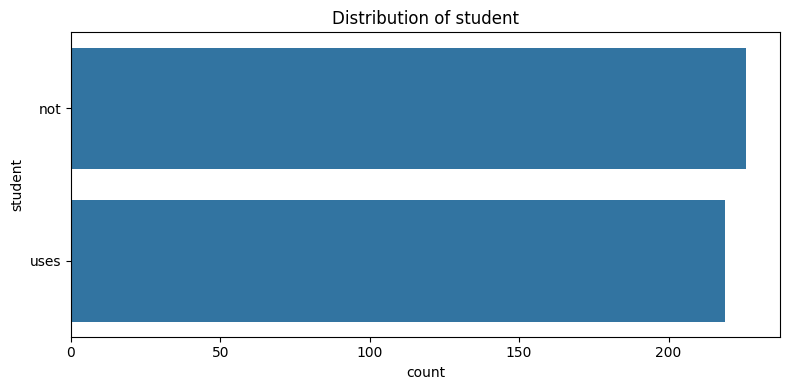


Value Counts for parents:
 parents
not     235
used    210
Name: count, dtype: int64


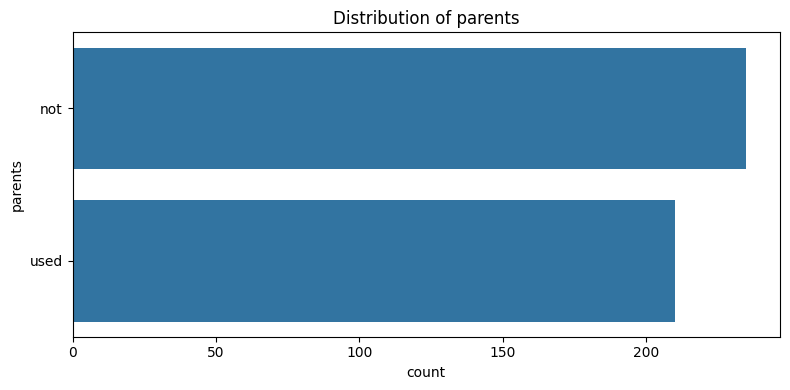


===== EDA Complete =====


In [5]:
# call the function
perform_eda(drug_use)

In [6]:
drug_use.head()

,student,parents
0,uses,used
1,uses,used
2,uses,used
3,uses,used
4,uses,used


In [7]:
# divide into target and predictor variables
X = drug_use['parents']
y = drug_use['student']

In [8]:
# use label encoder to encode the variables
label = LabelEncoder()
X = label.fit_transform(X)
y = label.fit_transform(y)

In [9]:
# Assuming label is the LabelEncoder instance
classes = label.classes_
encoded_classes = label.transform(label.classes_)

# Create a dictionary to map original classes to encoded values
class_mapping = dict(zip(classes, encoded_classes))

print(class_mapping)


{'not': np.int64(0), 'uses': np.int64(1)}


In [10]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
# reshape data 
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

In [15]:
# using logistic regression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.673469387755102
Confusion Matrix:
[[47 25]
 [23 52]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66        72
           1       0.68      0.69      0.68        75

    accuracy                           0.67       147
   macro avg       0.67      0.67      0.67       147
weighted avg       0.67      0.67      0.67       147



C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


In [12]:
# use a Random forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred1 = rf_clf.predict(X_test)

# Evaluate the model
accuracy1 = accuracy_score(y_test, y_pred1)
conf_matrix1 = confusion_matrix(y_test, y_pred1)
class_report1 = classification_report(y_test, y_pred1)

print(f"Accuracy: {accuracy1}")
print("Confusion Matrix:")
print(conf_matrix1)
print("Classification Report:")
print(class_report1)


Accuracy: 0.673469387755102
Confusion Matrix:
[[47 25]
 [23 52]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66        72
           1       0.68      0.69      0.68        75

    accuracy                           0.67       147
   macro avg       0.67      0.67      0.67       147
weighted avg       0.67      0.67      0.67       147



In [13]:
# using the xg boost
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False)
xgb_clf.fit(X_train, y_train)

y_pred2 = xgb_clf.predict(X_test)

accuracy2 = accuracy_score(y_test, y_pred2)
conf_matrix2 = confusion_matrix(y_test, y_pred2)
class_report2 = classification_report(y_test, y_pred2)

print(f"Accuracy: {accuracy2}")
print("Confusion Matrix:")
print(conf_matrix2)
print("Classification Report:")
print(class_report2)

Accuracy: 0.673469387755102
Confusion Matrix:
[[47 25]
 [23 52]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66        72
           1       0.68      0.69      0.68        75

    accuracy                           0.67       147
   macro avg       0.67      0.67      0.67       147
weighted avg       0.67      0.67      0.67       147



C:\Users\alber\anaconda3\envs\Personal\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [16]:
from sklearn.metrics import f1_score

# Calculate F1 scores for each model
f1_lr = f1_score(y_test, y_pred, average='weighted')  # Logistic Regression
f1_rf = f1_score(y_test, y_pred1, average='weighted')  # Random Forest
f1_xgb = f1_score(y_test, y_pred2, average='weighted')  # XGBoost

# Print F1 scores
print(f"F1 Score (Logistic Regression): {f1_lr}")
print(f"F1 Score (Random Forest): {f1_rf}")
print(f"F1 Score (XGBoost): {f1_xgb}")


F1 Score (Logistic Regression): 0.6733181041134023
F1 Score (Random Forest): 0.6733181041134023
F1 Score (XGBoost): 0.6733181041134023
